In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.station_network import StationNetworkSimul
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
from tqdm import tqdm
import pickle

In [4]:
df_stations = pd.read_csv('data/pau_challenge/plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("data/pau_challenge/position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('data/pau_challenge/passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)

In [5]:
path_flows = df_flow[['de', 'vers', 'nombre']].to_dict('records')

In [6]:
test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [13]:
test_network.set_edges_weights()
test_network.set_nodes_traffic(path_flows=path_flows)

In [7]:
def create_degraded_networks(net_simul : StationNetworkSimul, num_delete, num_degraded, data_dir):
    degraded_graphs = []
    for i in tqdm(range(num_degraded), total=num_degraded):
        new_net, removed_edges = net_simul.get_degraded_network(num_delete=num_delete)
        hash_removed  = hash(tuple(sorted(removed_edges)))
        
        os.makedirs(os.path.join(data_dir, f'delete_{num_delete}'), exist_ok=True)
        degraded_graph_path  = os.path.join(data_dir, f'delete_{num_delete}', f'{hash_removed}.gpickle')
        if os.path.exists(degraded_graph_path):
            # print(f"Getting graph {hash_removed} from precomputed data")
            with open(degraded_graph_path, 'rb') as f:
                new_net = pickle.load(f)
        else:
            # print(f"Creating and saving graph {hash_removed}")
            net_simul.update_degraded_network_nodes_traffic(new_net, removed_edges, df_flow)
            with open(degraded_graph_path, 'wb') as f:
                pickle.dump(new_net, f)
        degraded_graphs.append(new_net)
    return degraded_graphs
        

In [10]:
# Comment for TP evaluation
#  for i in range(2,11):
#     create_degraded_networks(test_network, num_delete=i, num_degraded=100, data_dir="graph_dataset/")

# create_degraded_networks(test_network, num_delete=1, num_degraded=200, data_dir="graph_dataset/")

In [9]:
data_dir = "graph_dataset/"

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [ ]:
# Takes around 7 minutes
for i in range(2,3):
    create_degraded_networks(test_network, num_delete=i, num_degraded=100, data_dir=data_dir)

In [21]:
def MAPE_loss(y_pred, y_true, mean=True):
    """
    Compute the Mean Absolute Percentage Error for the model predictions.

    Inputs:
        - y_pred : model predictions
        - y_true : true values
    
    Return:
        MAPE : Mean Absolute Percentage Error
    """

    APE = torch.abs(y_pred - y_true)/torch.abs(y_true)
    if mean:
        APE = torch.mean(APE)
    return APE

## GCN Models

### Using node position as input

In [10]:
train_degraded_graphs = []
dev_degraded_graphs = []
test_degraded_graphs = []

for i in range(2,3): # For TP evaluation i=2
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []

    print(f"Number of graphs where {i} edges were deleted: {len(all_files)}")
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        
        tensor_positions = torch.tensor([[node['x'], node['y']] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        tensor_edges = torch.tensor([
            [edge[0] for edge in new_net.edges],
            [edge[1] for edge in new_net.edges]
            ], dtype=torch.long)
        tensor_traffic = torch.tensor([node['traffic'] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        data_graph = Data(x=tensor_positions, edge_index=tensor_edges, y=tensor_traffic)
        degraded_graphs.append(data_graph)

    train_split_idx = int(0.9*len(all_files))
    dev_split_idx = int(0.1*train_split_idx)

    dev_degraded_graphs.extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs.extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs.extend(degraded_graphs[train_split_idx:])

Number of graphs where 2 edges were deleted: 203


In [11]:
train_loader = DataLoader(train_degraded_graphs, shuffle=True)
dev_loader = DataLoader(dev_degraded_graphs, shuffle=True)
test_loader = DataLoader(test_degraded_graphs, shuffle=True)

In [12]:
from gnn_model import QuantileGCN

In [13]:
# Instanciation du modèle
hidden_dim = 16
nodes_gnn_model = QuantileGCN(in_channels=2, hidden_channels=hidden_dim)
optimizer = torch.optim.Adam(nodes_gnn_model.parameters(), lr=0.01)

In [14]:
# Fonction de perte quantile
def quantile_loss(y_pred, y_true, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = y_true - y_pred[:, i]
        loss = torch.max(q * errors, (q - 1) * errors).mean()
        losses.append(loss)
    return sum(losses)

In [ ]:
epochs = 200

# Entraînement du modèle
for epoch in tqdm(range(epochs)):
    nodes_gnn_model.train()
    train_loss = []
    for data in train_loader:
        nodes_gnn_model.train()
        optimizer.zero_grad()
        x, edge_index = data.x, data.edge_index
        output = nodes_gnn_model(x, edge_index)
        # loss = criterion(output.squeeze(), data.y)
        loss = quantile_loss(output.squeeze(), data.y, nodes_gnn_model.quantiles)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    # dev_loss = []
    # nodes_gnn_model.eval()
    # for data in dev_loader:
    #     x, edge_index = data.x, data.edge_index
    #     output = nodes_gnn_model(x, edge_index)
    #     loss = MAPE_loss(output.squeeze(), data.y)
    #     dev_loss.append(loss.item())
    # print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. MAPE: {np.mean(dev_loss)}')


In [28]:
y_true = train_loader.dataset[0].y

In [29]:
preds = nodes_gnn_model(x, edge_index).detach().numpy()

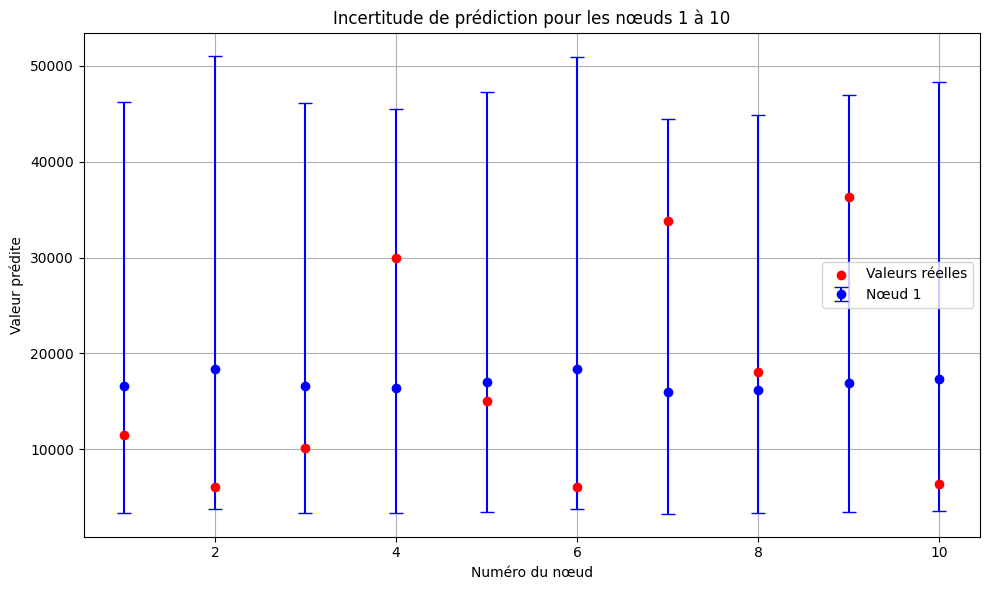

In [30]:
# Affichage des prédictions avec incertitude pour les nœuds 1 à 10
plt.figure(figsize=(10,6))

# Itération sur les nœuds 1 à 10
for node_idx in range(10):
    q_low, q_med, q_high = preds[node_idx]
    
    # Affichage des intervalles de prédiction pour chaque nœud
    plt.errorbar(node_idx + 1, q_med, 
                 yerr=[[q_med - q_low], [q_high - q_med]], 
                 fmt='o', capsize=5, label=f'Nœud {node_idx + 1}' if node_idx == 0 else "", color='blue')

# Affichage des valeurs réelles pour chaque nœud
plt.scatter(range(1, 11), y_true[:10].detach().numpy(), color='red', label="Valeurs réelles", zorder=5)

# Configuration du graphique
plt.legend()
plt.xlabel("Numéro du nœud")
plt.ylabel("Valeur prédite")
plt.title("Incertitude de prédiction pour les nœuds 1 à 10")
plt.grid(True)
plt.tight_layout()
plt.show()